In [19]:
import jax
import jax.numpy as jnp
import equinox as eqx
from jax import random
import optax
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [2]:
N_EPOCHS = 3000
LEARNING_RATE = 1e-3
BC_LOSS_WEIGHT = 1.0
N_DOF_FD = 100
N_COLLOCATION_POINTS = 20000
nu = 0.01 / jnp.pi

In [3]:
key = random.PRNGKey(42)

In [4]:
key, model_key = random.split(key)
pinn = eqx.nn.MLP(
    in_size=2,
    out_size="scalar",
    width_size=32,
    depth=4,
    activation=jax.nn.gelu,
    key=model_key,
)

In [5]:
pinn(jnp.array([0, 1]))

Array(-0.08504868, dtype=float32)

In [6]:
test = jnp.repeat(jnp.array([0, 1])[jnp.newaxis, :], 10, axis=0)
jax.vmap(pinn)(test)

Array([-0.08504868, -0.08504868, -0.08504868, -0.08504868, -0.08504868,
       -0.08504868, -0.08504868, -0.08504868, -0.08504868, -0.08504868],      dtype=float32)

In [7]:
def plot_prediction(mesh, model):
    mesh_x, mesh_y = mesh

    # Flatten the meshgrid arrays
    mesh_x_flat = mesh_x.flatten()
    mesh_y_flat = mesh_y.flatten()

    # Stack the flattened arrays to create the input for the model
    mesh_points = jnp.stack([mesh_x_flat, mesh_y_flat], axis=-1)

    # Apply the model using vmap
    predictions = jax.vmap(model)(mesh_points)

    # Reshape the predictions to match the original meshgrid shape
    predictions_reshaped = predictions.reshape(mesh_x.shape)

    plt.subplots()
    plt.figure(figsize=(8, 6))
    plt.scatter(mesh_y, mesh_x, c=predictions_reshaped, cmap="jet")
    plt.colorbar()
    plt.ylabel("x")
    plt.xlabel("t")
    plt.title("Prediction of Burger's Equation using PINN")  

/var/folders/2h/yypwh_6j3xq21vcnxr6g082w0000gn/T/ipykernel_34302/3595001488.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_prediction(mesh, pinn).show()


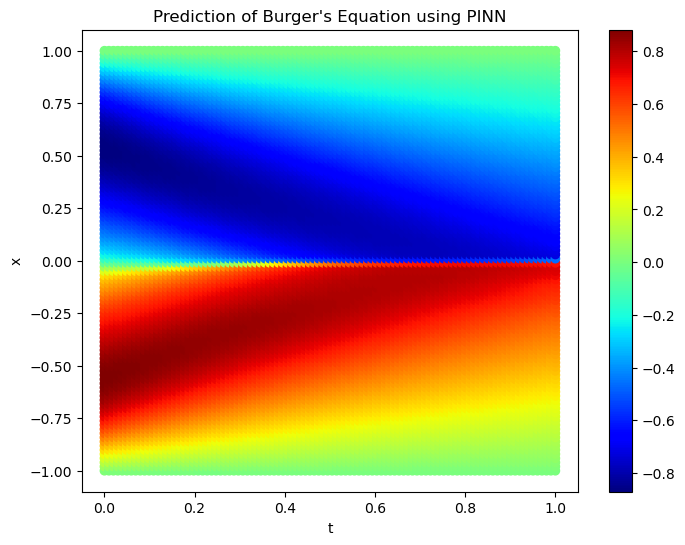

In [20]:
mesh = jnp.meshgrid(jnp.linspace(-1, 1, N_DOF_FD + 2), jnp.linspace(0, 1, N_DOF_FD + 2))
plot_prediction(mesh, pinn).show()

In [10]:
jax.grad(pinn)(jnp.array([0.1, 1.0]))

Array([-0.0001918 ,  0.00324476], dtype=float32)

In [11]:
def pde_residuum(model, x, t, nu):
    u = model(jnp.array([x, t]))  # Evaluate the model at (x, t)

    # Compute the partial derivatives
    u_t = jax.grad(model)(jnp.array([x, t]))[1]
    u_x = jax.grad(model)(jnp.array([x, t]))[0]
    u_xx = jax.hessian(model)(jnp.array([x, t]))[0, 0]

    # Compute the PDE residual
    residual = u_t + u * u_x - nu * u_xx
    return residual


pde_residuum(pinn, 0.1, 0.1, nu)

Array(0.00328372, dtype=float32)

In [12]:
# Generate synthetic training data
def generate_data(key, num_points=1000):
    x_key, t_key = random.split(key)
    eps = 1e-3
    x = random.uniform(x_key, (num_points,), minval=-1 + eps, maxval=1 - eps)
    t = random.uniform(t_key, (num_points,), minval=0 + eps, maxval=1 - eps)
    return x, t


x, t = generate_data(key, N_COLLOCATION_POINTS)

In [13]:
# Loss function
def loss_fn(model):
    pde_res = jax.vmap(pde_residuum, in_axes=(None, 0, 0, None))(model, x, t, nu)
    pde_loss = 0.5 * jnp.mean(jnp.square(pde_res))

    x0 = jnp.stack([x, jnp.zeros_like(x)], axis=-1)
    ic_res = jax.vmap(model)(x0) + jnp.sin(jnp.pi * x)
    ic_loss = 0.5 * jnp.mean(jnp.square(ic_res))

    lbc = jnp.stack([-jnp.ones_like(t), t], axis=-1)
    left_bc_res = jax.vmap(model)(lbc)
    left_bc_loss = 0.5 * jnp.mean(jnp.square(left_bc_res))

    rbc = jnp.stack([jnp.ones_like(t), t], axis=-1)
    right_bc_res = jax.vmap(model)(rbc)
    right_bc_loss = 0.5 * jnp.mean(jnp.square(right_bc_res))

    bc_loss = left_bc_loss + right_bc_loss

    return pde_loss + (ic_loss + bc_loss) * BC_LOSS_WEIGHT

In [14]:
loss_fn(pinn)

Array(0.2618699, dtype=float32)

In [15]:
# Initialize optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))


# Training step
@eqx.filter_jit
def train_step(model, state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, new_state = optimizer.update(grads, state)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

In [16]:
# Training loop
loss_history = []
for epoch in tqdm(range(N_EPOCHS)):
    pinn, opt_state, loss = train_step(pinn, opt_state)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")


# Store the trained model
eqx.tree_serialise_leaves("pinn.eqx", pinn)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0, Loss: 0.2618699073791504
Epoch 100, Loss: 0.19625282287597656
Epoch 200, Loss: 0.07926984876394272
Epoch 300, Loss: 0.07709674537181854
Epoch 400, Loss: 0.07445332407951355
Epoch 500, Loss: 0.0646255761384964
Epoch 600, Loss: 0.055032629519701004
Epoch 700, Loss: 0.050335559993982315
Epoch 800, Loss: 0.04646248370409012
Epoch 900, Loss: 0.04148901626467705
Epoch 1000, Loss: 0.037875350564718246
Epoch 1100, Loss: 0.03564979135990143
Epoch 1200, Loss: 0.033579301089048386
Epoch 1300, Loss: 0.03092607483267784
Epoch 1400, Loss: 0.028701258823275566
Epoch 1500, Loss: 0.026712823659181595
Epoch 1600, Loss: 0.024531424045562744
Epoch 1700, Loss: 0.022418400272727013
Epoch 1800, Loss: 0.020647209137678146
Epoch 1900, Loss: 0.01909896358847618
Epoch 2000, Loss: 0.017370734363794327
Epoch 2100, Loss: 0.015842380002141
Epoch 2200, Loss: 0.014450577087700367
Epoch 2300, Loss: 0.013392047956585884
Epoch 2400, Loss: 0.01342420931905508
Epoch 2500, Loss: 0.011407705955207348
Epoch 2600, Los

In [ ]:
# load the trained model
pinn = eqx.tree_deserialise_leaves("pinn.eqx")

/var/folders/2h/yypwh_6j3xq21vcnxr6g082w0000gn/T/ipykernel_34302/3894737343.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


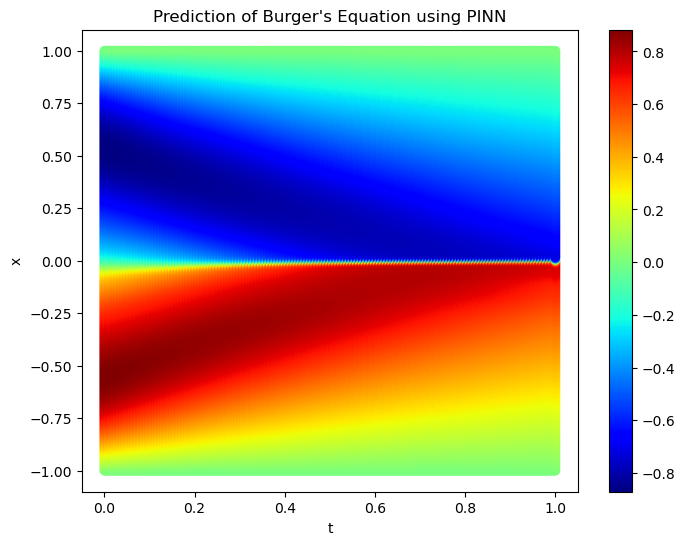

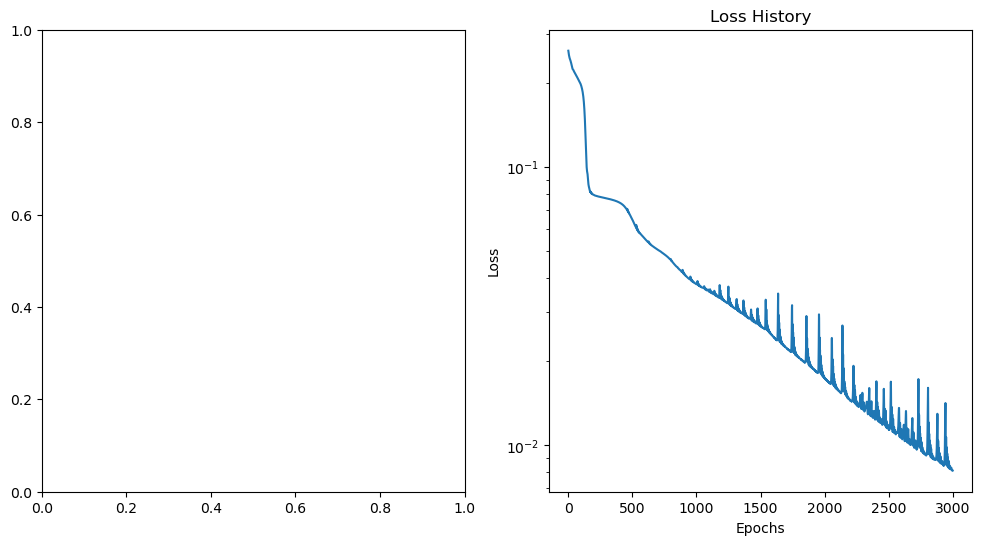

In [18]:
x_pred = jnp.linspace(-1, 1, 300)
t_pred = jnp.linspace(0, 1, 300)
fig = plot_prediction(jnp.meshgrid(x_pred, t_pred), pinn)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fig.show()

plt.subplot(1, 2, 2)
plt.semilogy(loss_history)
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

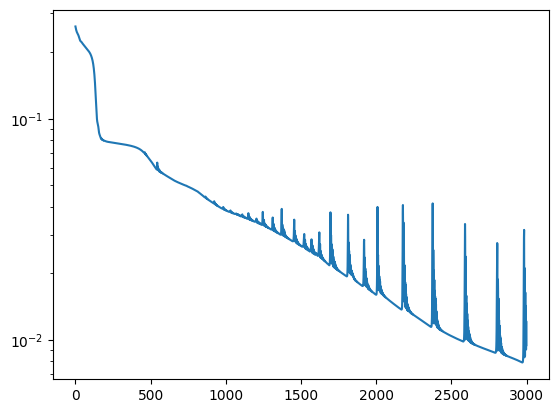

In [138]:
plt.semilogy(loss_history)